# 6. Sensitivity Analysis

In this example, we want to engineer a pathway for the production of a heterologous protein through a batch reaction. Increasing the strength of the rbs would result in faster synthesis. However, suppose the protein product has a negative (toxic) effect on the growth of the cells and high levels of expression may reduce growth to the point of decreasing yield. 

We want to consider how the yield at 7 hours is affected by changing the rbs strength (synh) and extent of growth inhibition(Kh). In addition, we have two strains of bacteria that we want to study; a fast-growing one and a slow-growing one (this affects mu_max).


First we import the required modules.

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd


import BMSS.models.model_handler as mh
import BMSS.models.setup_sen     as ss
import BMSS.sensitivityanalysis  as sn

Connected to MBase_models, UBase_models
Connected to MBase_settings, UBase_settings


We then produce a simple model using the config files. One file for the core model.

```
[system_type]
system_type = TestModel, Monod, Constitutive, Single, ProductInhibition

[states]
states = x, s, h

[parameters]
parameters = mu_max, Ks, Kh, Y, synh

[equations]
equations = 
	mu = mu_max*s/(s+Ks)*Kh/(h+Kh)
	
	dx =  x*mu
	ds = -dx/Y
	dh = synh -h*mu

```

...and another for the settings.
```
#Note 
#Parameter bounds will be automatically generated if they are not specified
#Automatically generated range: 0.1~10x
[TestModel, Monod, Constitutive, Single, ProductInhibition]
#id = bmss2
#equations = 
#	mu = mu_max*s/(s+Ks)*Kh/(h+Kh)
#	
#	dx =  x*mu
#	ds = -dx/Y
#	dh = synh -h*mu

init = 
	x      = [0.1]*2,
	s      = [0.2]*2,
	h      = [0]*2

parameter_values = 
	mu_max = [0.012, 0.010],
	Ks     = [0.15]*2,
	Kh     = [5e-5]*2,
	Y      = [4.5]*2,
	synh   = [1e-6]*2

units = 
	mu_max = 1/min,
	Ks     = % Glucose,
	Kh     = M,
	Y      = NONE,
	synh   = M/min

fixed_parameters = 
	[mu_max, Y]
	
tspan = 

	[0, 420]

solver_args = 
	rtol   = 1.49012e-08,
	atol   = 1.49012e-08,
	tcrit  = [],
	h0     = 0.0,
	hmax   = 0.0,
	hmin   = 0.0,
	mxstep = 0
```

We then define a function for calculating the final protein yield. This function must return a float.

In [2]:
def h_yield(y, t, params):
    final_x = y[-1, 0]
    final_h = y[-1, 2]

    return final_x*final_h


We now read the config files.

In [3]:
mh.quick_search('TestModel, Monod, Constitutive, Single, ProductInhibition')

{'id': 'bmss57',
 'system_type': 'TestModel, Monod, Constitutive, Single, ProductInhibition',
 'states': ['x', 's', 'h'],
 'parameters': ['mu_max', 'Ks', 'Kh', 'Y', 'synh'],
 'inputs': [],
 'equations': ['mu = mu_max*s/(s+Ks)*Kh/(h+Kh)',
  'dx =  x*mu',
  'ds = -dx/Y',
  'dh = synh -h*mu'],
 'ia': '',
 'descriptions': {}}

In [4]:
model_files = ['Monod_Constitutive_Single_ProductInhibition.ini',
               ]

user_core_models = [mh.from_config(filename) for filename in model_files]
user_core_models = {core_model['system_type']: core_model for core_model in user_core_models}


filename                      = 'settings_sen.ini'
sensitivity_args, config_data = ss.get_sensitivity_args(filename, user_core_models=user_core_models)
sensitivity_args['objective'] = {1: [h_yield]}

print(sensitivity_args['params'])

   mu_max_1  Ks_1     Kh_1  Y_1    synh_1
0     0.012  0.15  0.00005  4.5  0.000001
1     0.010  0.15  0.00005  4.5  0.000001


We have two sets of paramters, one for each strain. Before proceeding, let's rename the index of the DataFrame to make this clearer.

In [5]:
sensitivity_args['params'].index = ['Strain 1', 'Strain 2']

We now call the ```analyze``` function to run the sensitivity analysis algorithms from SALib. In this case, we use the Sobol algorithm but you can make use of SALib's other functions by changing the ```analysis_type``` under sensitivity_args.

In [6]:
analysis_result, em, samples, problems = sn.analyze(**sensitivity_args)

We now plot the results.

([<Figure size 864x360 with 2 Axes>, <Figure size 864x360 with 2 Axes>],
 {1: {1: {'Strain 1': {<function __main__.h_yield(y, t, params)>: <AxesSubplot:title={'center':'Model 1, Scenario 1 Strain 1, h Yield'}>}},
   2: {'Strain 2': {<function __main__.h_yield(y, t, params)>: <AxesSubplot:title={'center':'Model 1, Scenario 2 Strain 2, h Yield'}>}}}})

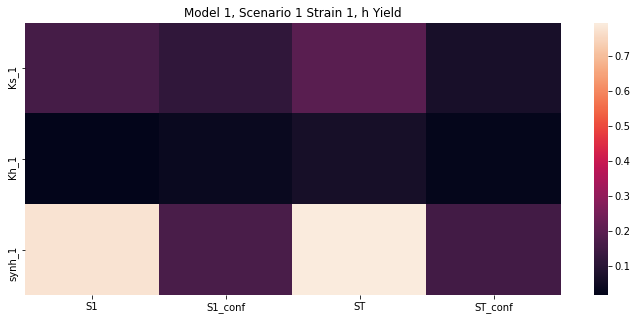

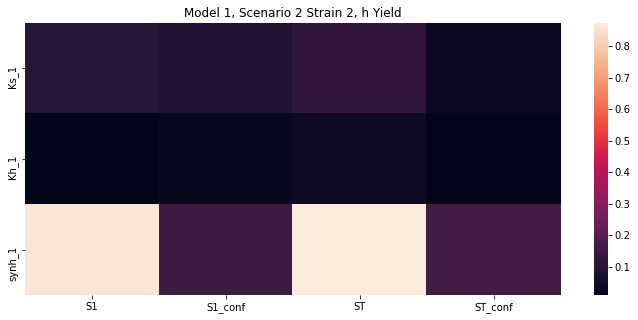

In [7]:
#Plot settings
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.subplot.hspace'] = 0.99

titles = {1: {h_yield: 'h Yield'}
          }
sn.plot_first_order(analysis_result, problems=problems, titles=titles, analysis_type=sensitivity_args['analysis_type'], figs=None, AX=None)

Sobol analysis includes second order sensitivities which can be used to check for correlated parameters. We can call ```plot_second_order``` to plot the second order sensitivity.


([<Figure size 864x360 with 4 Axes>, <Figure size 864x360 with 4 Axes>],
 {1: {1: {'Strain 1': {<function __main__.h_yield(y, t, params)>: {'S2': <AxesSubplot:title={'center':'Model 1, Scenario 1 Strain 1, h Yield (S2)'}>,
      'S2_conf': <AxesSubplot:title={'center':'Model 1, Scenario 1 Strain 1, h Yield (S2_conf)'}>}}},
   2: {'Strain 2': {<function __main__.h_yield(y, t, params)>: {'S2': <AxesSubplot:title={'center':'Model 1, Scenario 2 Strain 2, h Yield (S2)'}>,
      'S2_conf': <AxesSubplot:title={'center':'Model 1, Scenario 2 Strain 2, h Yield (S2_conf)'}>}}}}})

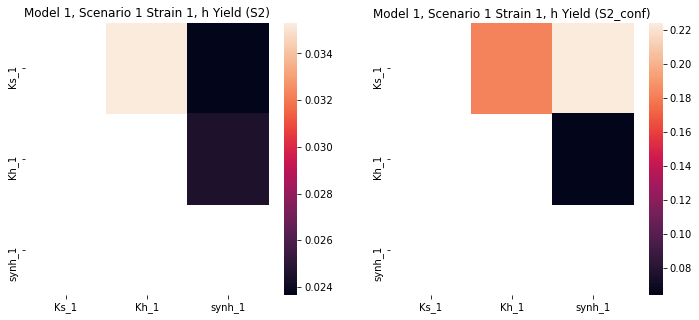

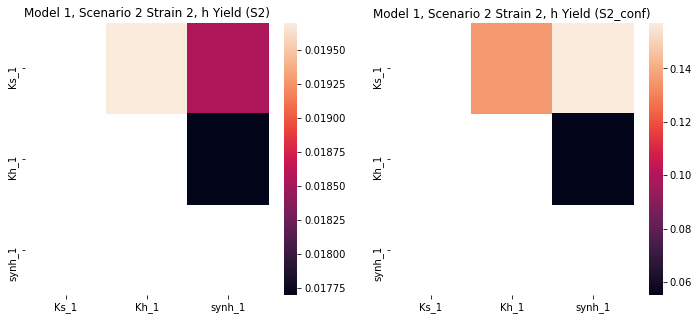

In [8]:
sn.plot_second_order(analysis_result, problems=problems, titles=titles, analysis_type=sensitivity_args['analysis_type'], figs=None, AX=None)

    